 Use fast AI for  writing a detailed colab (no copy paste from hints) - which show training and inference of below tasks using fast.ai - showcase results metrics .






vision segmentation task

recommendation task

# **1)vision segmentation task**



In [1]:
import torch

In [2]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.CAMVID)

In [4]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

In [5]:
def ListSplitter(valid_items):
    def _inner(items):
        val_mask = tensor([o.name in valid_items for o in items])
        return [~val_mask,val_mask]
    return _inner

In [6]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [7]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
                   batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)])

dls = camvid.dataloaders(path/"images", bs=8)

In [8]:
dls = SegmentationDataLoaders.from_label_func(path, bs=8,
    fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = codes,
    batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)])

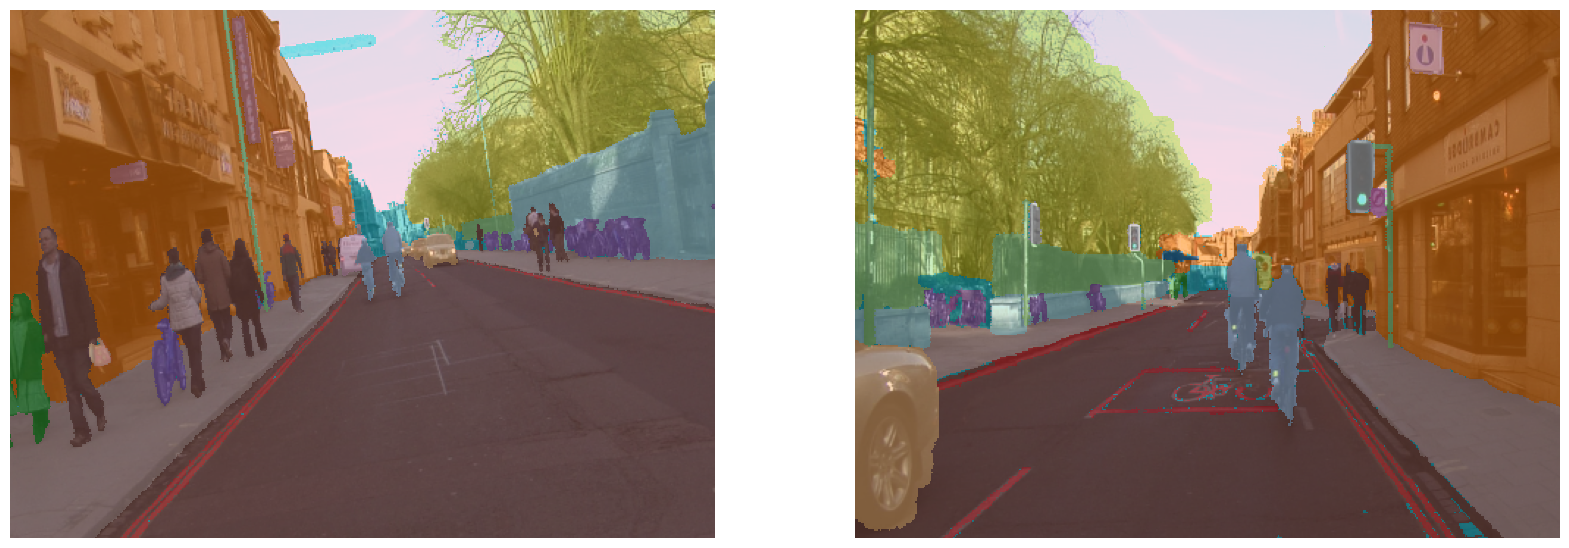

In [9]:
dls.show_batch(max_n=2, figsize=(20, 7))

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
dls.vocab = codes

In [11]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [12]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)#, eps=1e-8)

learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), opt_func=opt_func, path=path, metrics=acc_camvid,
                     norm_type=None, wd_bn_bias=True)

In [13]:
get_c(dls)

32

In [14]:
#learn.lr_find(num_it=100)

In [15]:
lr= 3e-3
learn.freeze()

In [16]:
learn.fit_one_cycle(1, slice(lr), pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.386201,0.961382,0.747591,51:48


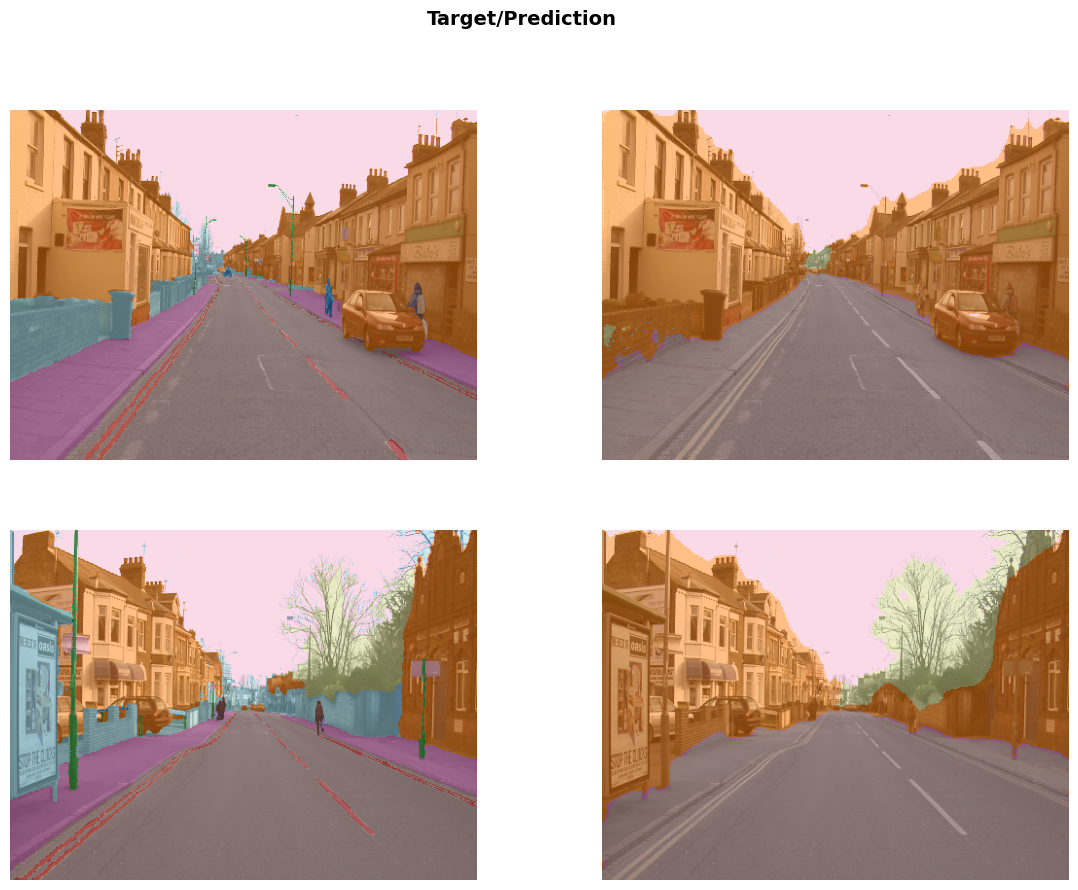

In [18]:
#learn.show_results(max_n=2, rows=2, vmin=1, vmax=30, figsize=(14, 10))
learn.show_results(max_n=2, vmin=1, vmax=30, figsize=(14, 10))


In [16]:
learn.save('stage-1')

Path('C:/Users/amart/.fastai/data/camvid/models/stage-1.pth')

In [17]:
learn.load('stage-1')
learn.unfreeze()

In [18]:
lrs = slice(lr/400,lr/4)

In [19]:
learn.fit_one_cycle(1, lrs, pct_start=0.8, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.211517,0.701787,0.838175,55:16


In [ ]:
learn.show_results(max_n=4, vmin=1, vmax=30, figsize=(15,6))